# Max Cut QAOA - Pennylane

In this notebook, we present an implementation of the Hybrid Max-Cut QAOA using Xanadu's Pennylane Python framework. [Here](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html) is the source for much of this code.

For general information about the maxcut problem, see [here](https://en.wikipedia.org/wiki/Maximum_cut), and for an explanation of QAOA, [here](https://www.youtube.com/watch?v=YpLzSQPrgSc&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=13).

While true hybrid classical-quantum compilation should generate a unified IR, we use this as an intermediate step in order to gain a clearer understanding of which aspects of the transpiled quantum circuit change iteration-by-iteration. This will enable us to decide whether a single transpilation might suffice, or whether each iteration requires its own transpilation.

The first step is to import the Pennylane package and set up the graph on which we will search for the maxcut. Make sure you have Pennylane installed:
```terminal
pip install pennylane
```

In [1]:
import pennylane as qml
from pennylane import numpy as np

n_vertices = 4
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]

As you can see, we specify the number of vertices and define the edge list of the graph. Visually, our graph looks like this:

![Graph in question](graph.png)

Next, we define the unitaries which will comprise the mixing and cost layers of our QAOA.

In [2]:
n_qubits = n_vertices

# Mixing operator, which appplies a parameterized single-qubit X rotation gate to each qubit
def U_B(beta_i):
    for qubit in range(n_qubits):
        qml.RX(2 * beta_i, wires = qubit)

# The cost operator entangles each pair of qubits which share an edge in the graph
def U_C(gamma_i):
    for edge in graph:
        qubit1 = edge[0]
        qubit2 = edge[1]
        qml.CNOT(wires = [qubit1, qubit2])
        qml.RZ(gamma_i, wires = qubit2)
        qml.CNOT(wires = [qubit1, qubit2])

With these custom unitarys in hand, we can continue on to build the quantum circuit and specify the quantum backend it will run on. We put all of the qubits in a uniform superposition with Hadamard gates, perform the cost and mixing steps _p_ times, and then measure some subset of qubits (or _wires_, in the Pennylane terminology).

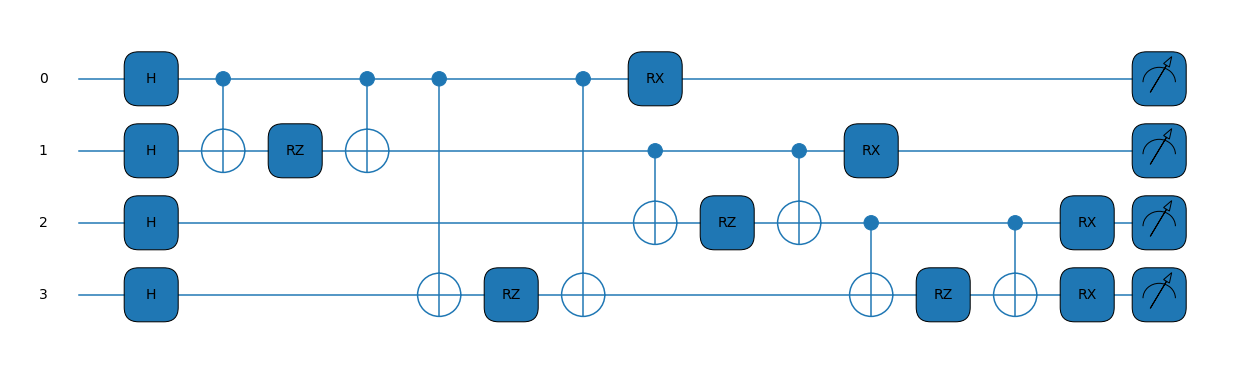

In [4]:
# Standard Pennylane backend
device = qml.device("default.qubit", wires = n_qubits, shots = 1)

# Used later to measure particular qubit pairs in the computational basis
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z, requires_grad = False)

# The central circuit of the QAOA: Hadamards, (Cost + Mixing) * p, Measurement
def circ(gammas, betas, edge=None, p=1):
    for qubit in range(n_qubits):
        qml.Hadamard(wires = qubit)
    
    for i in range(p):
        U_C(gammas[i])
        U_B(betas[i])

    if edge is None:
        return qml.sample()

    return qml.expval(qml.Hermitian(pauli_z_2, wires = edge))

# We marks this function as a "QNode", meaning it should be run on quantum hardware, and we specify the device
circuit = qml.QNode(circ, device)

fig, ax = qml.draw_mpl(circuit)([1.0], [1.0])

Finally, we define a utility function `bitstring_to_int` for converting between bit strings and base 10 integers. Now, we're ready to run our QAOA. This takes place in several steps:

1. Initialize parameters. we somewhat arbitrarily choose gamma, beta = [1.0, 1.0]. If p were > 1, there would of course be more parameters to initialize.
2. Define the "objective" or "cost" function we wish the classical optimizer to operate on
3. Call the classical optimizer, which kicks off a loop:
    + Run the objective with current parameters
    + Change parameters in a direction which will decrease the objective (gradient descent)
    + Repeat until the gradient becomes small enough or the max iteration bound is reached

Here, what concerns us is not primarily the answer (it's a simple enough graph to eyeball the answer), but rather how the quantum circuit changes through an iteration. So, we only allow the optimizer to perform one iteration. The initial objective value, updated parameters, and updated objective function are all printed, as well as the "solution" to the maxcut instance. Note that because `p = 1` and we are only doing one optimization iteration, this will be a very poor approximation, but that's ok.

In [5]:
# A utility function, used below to translate encode measurements
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

def qaoa_maxcut(p=1):
    print("\np={:d}".format(p))

    # Initialize parameters: Beta = 1, Gamma = 1
    init_params = np.array([[1.0], [1.0]], requires_grad = True)

    # Minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, p=p))
        return neg_obj
    
    print("Initial objective: {: .7f}".format(-objective(init_params)))

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 1
    for i in range(steps):
        params = opt.step(objective, params)
        # if (i + 1) % 5 == 0:
        print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # Once we've arrived at an optimum, sample bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit(params[0], params[1], edge=None, p=p)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :p]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
bitstrings1 = qaoa_maxcut(p=1)[1]




p=1
Initial objective:  4.0000000
Objective after step     1:  2.0000000
Optimized (gamma, beta) vectors:
[[0.5]
 [1.5]]
Most frequently sampled bit string is: 0011


To increase transparency into just what changes occur to the circuit, we will dump both the "before circuit" and the "after circuit" to OpenQASM (through Qiskit). Our main concern is whether changing the parameters in a simple variational circuit such as this one affects the _structure_ of the circuit in a way which would necessitate a separate transpilation for each iteration.

## Transpilation

Pennylane has several built in transpilation passes to optimize a circuit. They are available by specifying a _pipeline_, which is then passed into the `.compile()` transform. By default, its pipeline is 
```python
commute_controlled()
cancel_inverses()
merge_rotations()
```
which is sufficient.


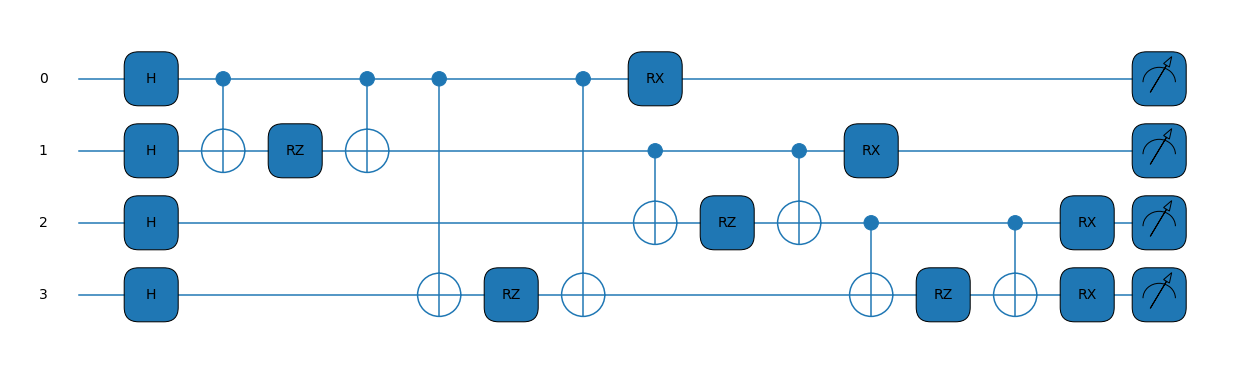

In [6]:
compiled_circ = qml.compile()(circ)
compiled_circuit = qml.QNode(compiled_circ, device)
fig, ax = qml.draw_mpl(compiled_circuit)([1.0], [1.0])

It turns out that this circuit is simple enough that the three transpilation passes don't cause any changes, which is fine for our purposes.

Finally, we want to transform our circuit to Qiskit in order to dump to OpenQASM. For this section, we will need to `pip install pennylane-qiskit`, for access to the `qiskit.aer` backend.

In [10]:
from qiskit import qasm3

# Make a new qnode targeted to the Qiskit Aer Simulator backend
dev = qml.device("qiskit.aer", wires = n_qubits)
qnode = qml.QNode(circ, dev)

# Running it once implicitly converts it to a Qiskit Circuit object, which allows us to dump OpenQASM\
# We use the initial parameters, so this is considered the "before" circuit
qnode([1.0], [1.0])

# OpenQASM2: dev._circuit.qasm(formatted=True)
print(qasm3.dumps(dev._circuit))

# Now, we run it with the new parameters generated by the optimizer after one iteration
# This is thus the "after" circuit
qnode([.5], [1.5])

print(qasm3.dumps(dev._circuit))

OPENQASM 3;
include "stdgates.inc";
bit[4] c;
qubit[4] _all_qubits;
let q = _all_qubits[0:3];
h q[0];
h q[1];
h q[2];
h q[3];
cx q[0], q[1];
rz(1) q[1];
cx q[0], q[1];
cx q[0], q[3];
rz(1) q[3];
cx q[0], q[3];
cx q[1], q[2];
rz(1) q[2];
cx q[1], q[2];
cx q[2], q[3];
rz(1) q[3];
cx q[2], q[3];
rx(2) q[0];
rx(2) q[1];
rx(2) q[2];
rx(2) q[3];
c[0] = measure q[0];
c[1] = measure q[1];
c[2] = measure q[2];
c[3] = measure q[3];

OPENQASM 3;
include "stdgates.inc";
bit[4] c;
qubit[4] _all_qubits;
let q = _all_qubits[0:3];
h q[0];
h q[1];
h q[2];
h q[3];
cx q[0], q[1];
rz(0.5) q[1];
cx q[0], q[1];
cx q[0], q[3];
rz(0.5) q[3];
cx q[0], q[3];
cx q[1], q[2];
rz(0.5) q[2];
cx q[1], q[2];
cx q[2], q[3];
rz(0.5) q[3];
cx q[2], q[3];
rx(3) q[0];
rx(3) q[1];
rx(3) q[2];
rx(3) q[3];
c[0] = measure q[0];
c[1] = measure q[1];
c[2] = measure q[2];
c[3] = measure q[3];



The [before](init.qasm) and [after](after.qasm) circuits are dumped to OpenQASM, and we note that the only difference lies in the values of the rotation gates, rather than in circuit structure. 

![QASM Diff](diff.png)

This is encouraging, as it suggests that a hybrid IR can re-utilize the same OpenQASM file which reaches into a single dynamic array and is updated by the classical optimizer. Then, a single transpilation of the variational circuit with initial parameters would suffice.